## USD / INR accounting for interest rates
### introduction 

As a migrant living in a developed county looking at the USD exchange rate makes saving in USD look like the obvious option. On the other hand my developing home country has much higher interest rates and I would like to take that into consideration when trying to compare saving options.

In [42]:
import numpy as np
import datetime
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters(datetime)

TypeError: register() takes 0 positional arguments but 1 was given

#### data used

Below is listed all the data i have used for this analysis :

from [ST. LOUIS FED](https://fred.stlouisfed.org/):

##### exchange rates
India / U.S. Foreign Exchange Rate (DEXINUS)<br/>
U.S. / Euro Foreign Exchange Rate (DEXUSEU)

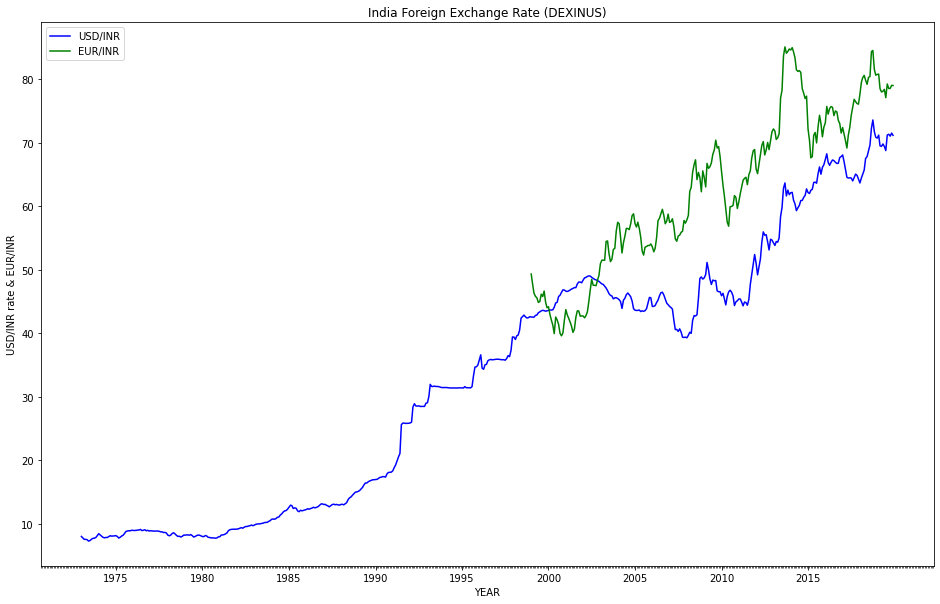

In [43]:
usdinr = pd.read_csv("DEXINUS.csv")
eurusd = pd.read_csv("DEXUSEU.csv")

# plotting
ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_minor_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
fig = plt.gcf() 
fig.set_size_inches(16,10)

plt.xticks(list(map(lambda x: datetime.date(x,1,1), list(range(1970,2020,5)))))

plt.xlabel('YEAR')
plt.ylabel('USD/INR rate & EUR/INR')
plt.title('India Foreign Exchange Rate (DEXINUS)')

mnths = list(map( lambda x: datetime.date(int(x[0:4]),int(x[5:7]),1),usdinr.DATE.tolist()))
mnths1 = list(map( lambda x: datetime.date(int(x[0:4]),int(x[5:7]),1),eurusd.DATE.tolist()))
plt.plot(mnths, usdinr.DEXINUS.tolist(), 'b', label='USD/INR')
plt.plot(mnths1, np.array(usdinr.truncate(before=312).DEXINUS)* np.array(eurusd.DEXUSEU), 'g', label='EUR/INR')
plt.legend(loc="upper left")
plt.savefig('plots/exchange_rate.png',  bbox_inches='tight')
plt.show()

##### interest rates
10-Year Treasury Constant Maturity Rate (DGS10)<br/>
Interest Rates, Government Securities, Government Bonds for India (INTGSBINM193N)<br/>
Interest Rates: Long-term government bond yields: 10-year: Main (including benchmark) for India  (INDIRLTLT01STM)<br/>
Long-Term Government Bond Yields: 10-year: Main (Including Benchmark) for the Euro Area (IRLTLT01EZM156N)

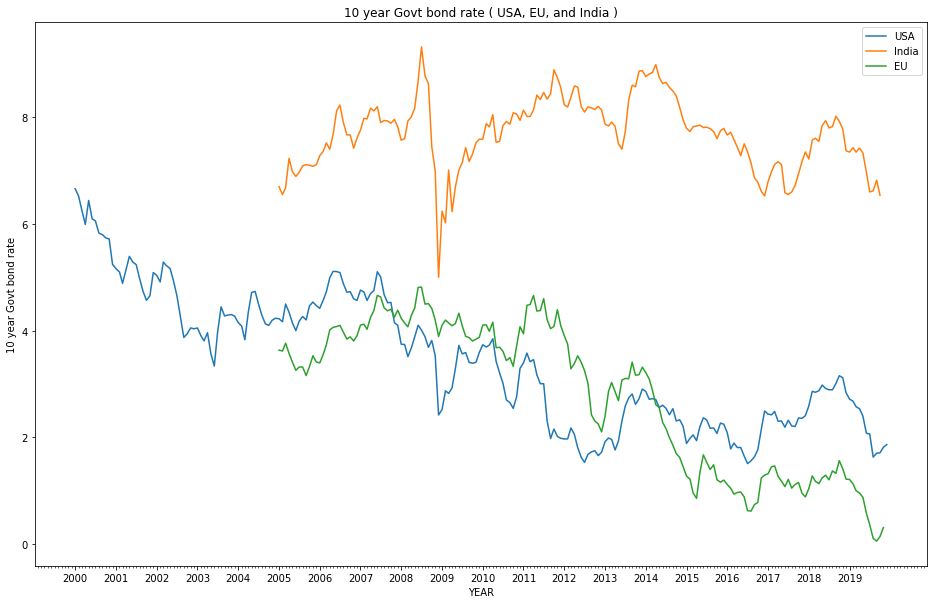

In [44]:
us_int = pd.read_csv("DGS10.csv")
in_int = pd.read_csv("INTGSBINM193N.csv").truncate(after=82).rename(columns={"INTGSBINM193N": "INDIRLTLT01STM"}).append(pd.read_csv("INDIRLTLT01STM.csv"), ignore_index = True)
eu_int = pd.read_csv("IRLTLT01EZM156N.csv").truncate(before=420)

# plotting
ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_minor_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

fig = plt.gcf() 
fig.set_size_inches(16,10)

plt.xticks(list(map(lambda x: datetime.date(x,1,1), list(range(2000,2020,1)))))

plt.xlabel('YEAR')
plt.ylabel('10 year Govt bond rate')
plt.title('10 year Govt bond rate ( USA, EU, and India )')

mnths = list(map( lambda x: datetime.date(int(x[0:4]),int(x[5:7]),1), us_int.DATE.tolist()))
mnths1 = list(map( lambda x: datetime.date(int(x[0:4]),int(x[5:7]),1), in_int.DATE.tolist()))
mnths2 = list(map( lambda x: datetime.date(int(x[0:4]),int(x[5:7]),1), eu_int.DATE.tolist()))

plt.plot(mnths, us_int.DGS10.tolist(), label="USA")
plt.plot(mnths1, in_int.INDIRLTLT01STM.tolist(), label="India")
plt.plot(mnths2, eu_int.IRLTLT01EZM156N.tolist(), label="EU")
plt.legend(loc="upper right")
plt.savefig('plots/bond_rate.png',  bbox_inches='tight')
plt.show()

for a later section I have also used some stock market indices: 
##### from yahoo finance:
S&P 500 Index
German DAX Index

##### from (bseindia.com)[https://www.bseindia.com/Indices/IndexArchiveData.html]:
BSE 500 Index

#### USB AND INB

For reasons that will become obvious later, let us create two imagnary funds USB and INB which will represent the current value of one unit currency saved at an earlier point. As the indian interest rates are only available from jan 2005, we will use that as the starting point and try to plot USB/USD and INB/INR

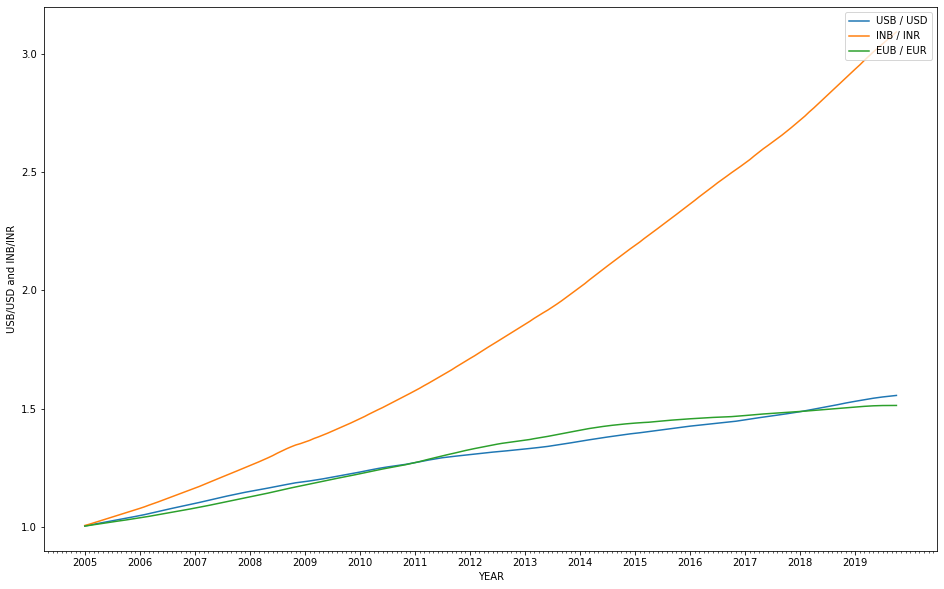

In [45]:
#clipping US data to match available india data
us_int1 = us_int.truncate(before=60, after=237).reset_index(drop=True)
eu_int1 = eu_int.truncate(before=420,after=597).reset_index(drop=True)

# emmulating quarterly compounding
def get_bond (interest) :
    bond = []
    principal = 1
    previous = 1
    
    for i in range(len(interest)):
        add = principal*interest[i]*0.01/12
        previous += add
        bond.append(previous)
        if i % 3 == 2 : principal = previous
    
    return bond

usb = get_bond(us_int1.DGS10.tolist())
inb = get_bond(in_int.INDIRLTLT01STM.tolist())
eub = get_bond(eu_int1.IRLTLT01EZM156N.tolist())

ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_minor_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

fig = plt.gcf() 
fig.set_size_inches(16,10)

plt.xticks(list(map(lambda x: datetime.date(x,1,1), list(range(2005,2020,1)))))

plt.xlabel('YEAR')
plt.ylabel('USB/USD and INB/INR')

mnths = list(map( lambda x: datetime.date(int(x[0:4]),int(x[5:7]),1), us_int1.DATE.tolist()))

plt.plot(mnths, usb, label="USB / USD")
plt.plot(mnths, inb, label="INB / INR")
plt.plot(mnths, eub, label="EUB / EUR")
plt.legend(loc="upper right")
plt.show()

#### plotting USB vs INB
For those conflicted between saving in their home country vs USA, plotting USB vs INB would be insightful. Here we can answer the question: how many Rupees in safe debt instruments do I need to shell out to buy a US dollar doing the same and how is this changing over time. To obtain USB/INB we will use the following formule:

USB/USD  $\times$  USD/INR  $\times$  INR/INB

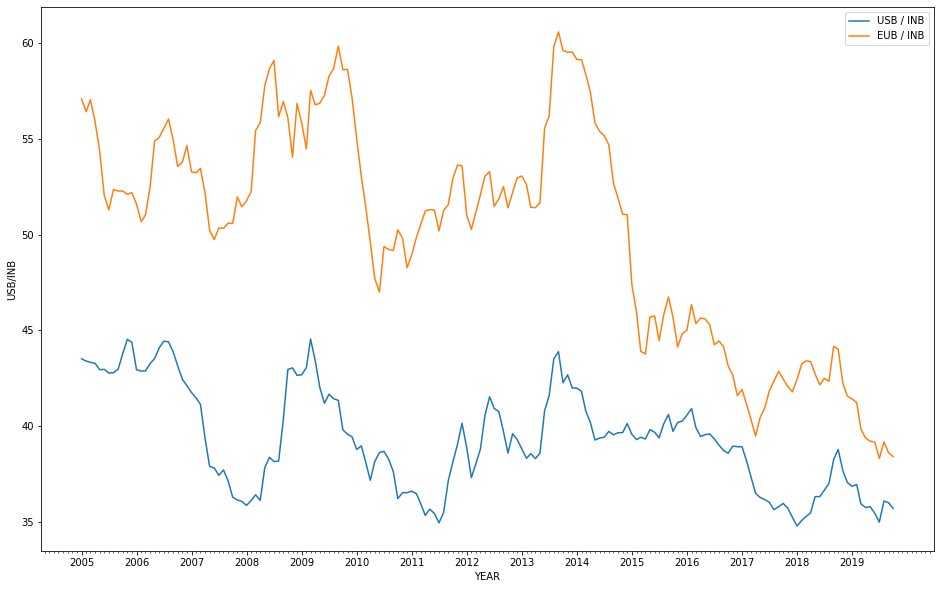

In [46]:
# truncating usd/inr to correspond to rest of data
us_fit = usdinr.truncate(before=384, after=561).DEXINUS.tolist()

ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_minor_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

fig = plt.gcf() 
fig.set_size_inches(16,10)

plt.xticks(list(map(lambda x: datetime.date(x,1,1), list(range(2005,2020,1)))))

plt.xlabel('YEAR')
plt.ylabel('USB/INB')

mnths = list(map( lambda x: datetime.date(int(x[0:4]),int(x[5:7]),1), us_int1.DATE.tolist()))

plt.plot(mnths, np.array(usb)*np.array(us_fit)/np.array(inb), label="USB / INB")
plt.plot(mnths, np.array(eub)*np.array(us_fit)*np.array(eurusd.truncate(before=72,after=249).DEXUSEU)/np.array(inb), label="EUB / INB")
plt.legend(loc="upper right")

plt.show()

Let us look at the same thing in relative terms

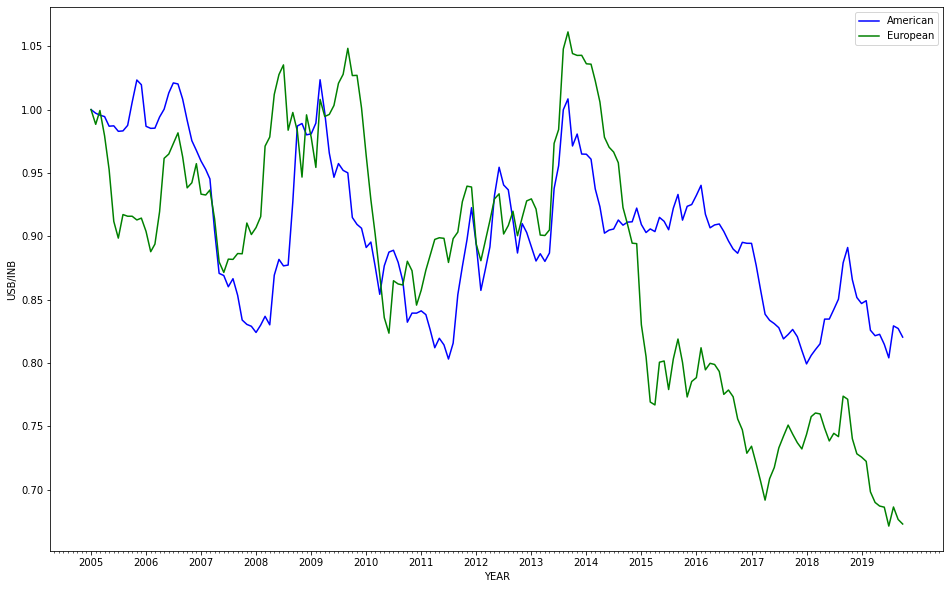

In [47]:
ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_minor_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

fig = plt.gcf() 
fig.set_size_inches(16,10)

plt.xticks(list(map(lambda x: datetime.date(x,1,1), list(range(2005,2020,1)))))

us_rry = np.array(usb)*np.array(us_fit)/np.array(inb)
eu_rry = np.array(eub)*np.array(us_fit)*np.array(eurusd.truncate(before=72,after=249).DEXUSEU)/np.array(inb)

plt.xlabel('YEAR')
plt.ylabel('USB/INB')

mnths = list(map( lambda x: datetime.date(int(x[0:4]),int(x[5:7]),1), us_int1.DATE.tolist()))

plt.plot(mnths, us_rry/us_rry[0], 'b', label="American")
plt.plot(mnths, eu_rry/eu_rry[0], 'g',label="European")
plt.legend(loc="upper right")

plt.savefig('plots/bond_rel.png',  bbox_inches='tight')
plt.show()

different view

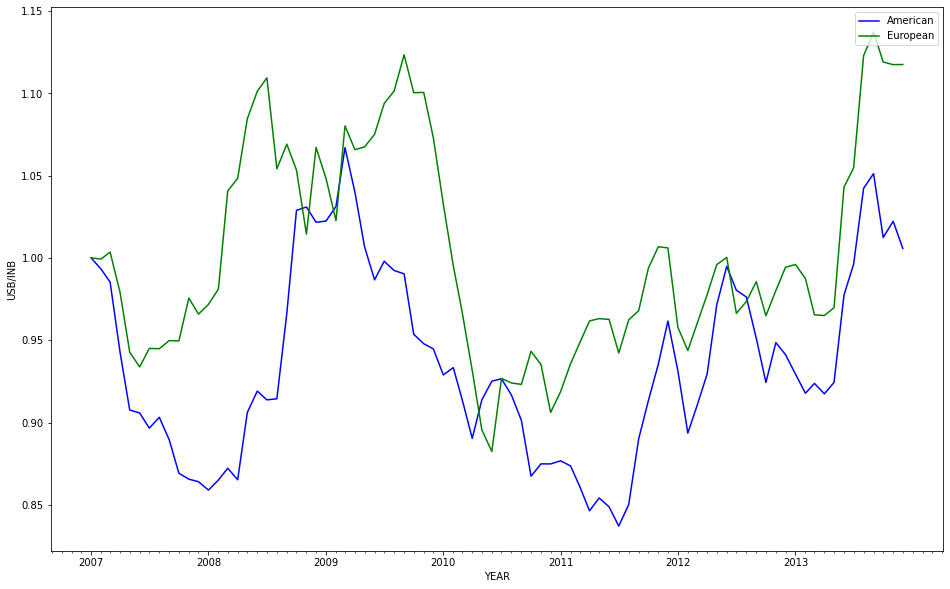

In [48]:
ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_minor_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

fig = plt.gcf() 
fig.set_size_inches(16,10)

plt.xticks(list(map(lambda x: datetime.date(x,1,1), list(range(2007,2014,1)))))

us_rry = us_rry[24:108]
eu_rry = eu_rry[24:108]

plt.xlabel('YEAR')
plt.ylabel('USB/INB')

mnths = mnths[24:108]

plt.plot(mnths, us_rry/us_rry[0], 'b', label="American")
plt.plot(mnths, eu_rry/eu_rry[0], 'g',label="European")
plt.legend(loc="upper right")

plt.savefig('plots/bond_rel_2.png',  bbox_inches='tight')
plt.show()

#### comparing equity investments

applying the earlier developed method we will now compare USE and INE where they both stand for a unit currency investment in comparable equity indexes. Here we are using BSE 500 and Dow Jones 500 (and the German DAX)

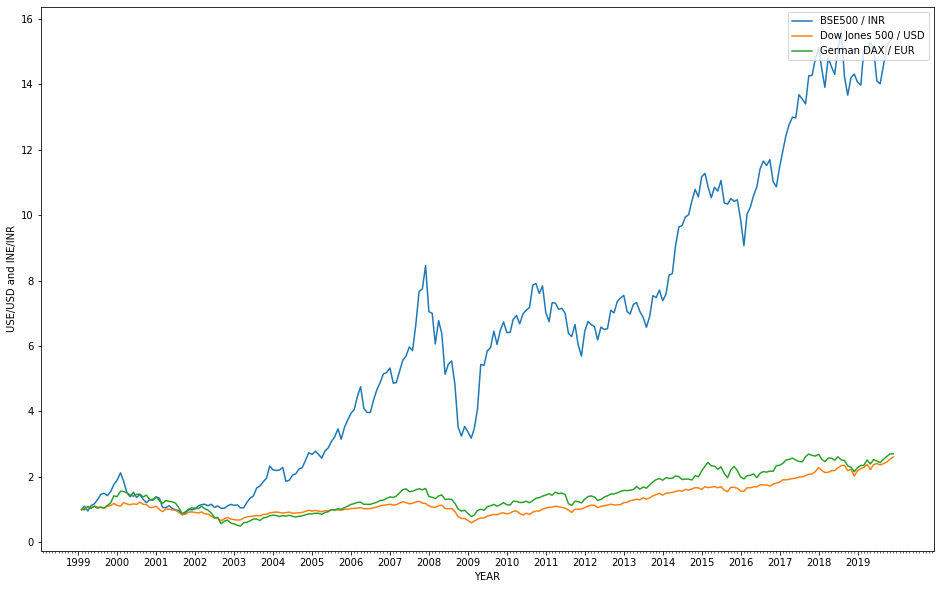

In [49]:
bse = dow = pd.read_csv("BSE500.csv")[['Low']].reset_index().truncate(after=250)
dow = pd.read_csv("^GSPC.csv")[['Date', 'Adj Close']].truncate(before=854,after=1104)
dax = pd.read_csv("^GDAXI.csv")[['Date', 'Adj Close']].truncate(before=134)

ine = bse.Low.tolist()
ine = np.array(ine) / ine[0]

use = dow['Adj Close'].tolist()
use = np.array(use) / use[0]

eue = dax['Adj Close'].tolist()
eue = np.array(eue) / eue[0]

ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_minor_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

fig = plt.gcf() 
fig.set_size_inches(16,10)

plt.xticks(list(map(lambda x: datetime.date(x,1,1), list(range(1999,2020,1)))))

plt.xlabel('YEAR')
plt.ylabel('USE/USD and INE/INR')

mnths = list(map( lambda x: datetime.date(int(x[0:4]),int(x[5:7]),1), dow.Date.tolist()))

plt.plot(mnths, ine, label="BSE500 / INR")
plt.plot(mnths, use, label="Dow Jones 500 / USD")
plt.plot(mnths, eue, label="German DAX / EUR")
plt.legend(loc="upper right")
plt.savefig('plots/equity.png',  bbox_inches='tight')
plt.show()

#### Plotting USE vs INE
using the same formule as before we plot USE vs INE

USE/USD  $\times$  USD/INR  $\times$  INR/INE

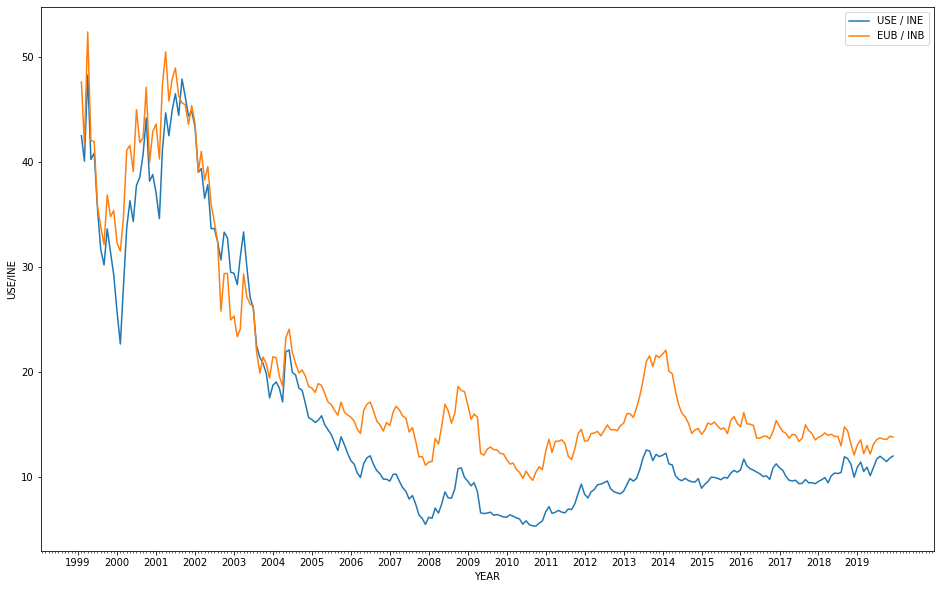

In [50]:
# truncating usd/inr to correspond to rest of data
us_fit =usdinr.truncate(before=313, after=563).DEXINUS.tolist()

ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_minor_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

fig = plt.gcf() 
fig.set_size_inches(16,10)

plt.xticks(list(map(lambda x: datetime.date(x,1,1), list(range(1999,2020,1)))))

plt.xlabel('YEAR')
plt.ylabel('USE/INE')

mnths = list(map( lambda x: datetime.date(int(x[0:4]),int(x[5:7]),1), dow.Date.tolist()))

plt.plot(mnths, np.array(use)*np.array(us_fit)/np.array(ine), label="USE / INE")
plt.plot(mnths, np.array(eue)*np.array(us_fit)*np.array(eurusd.truncate(before=1,after=251).DEXUSEU)/np.array(ine), label="EUB / INB")
plt.legend(loc="upper right")
plt.show()

in realtive terms

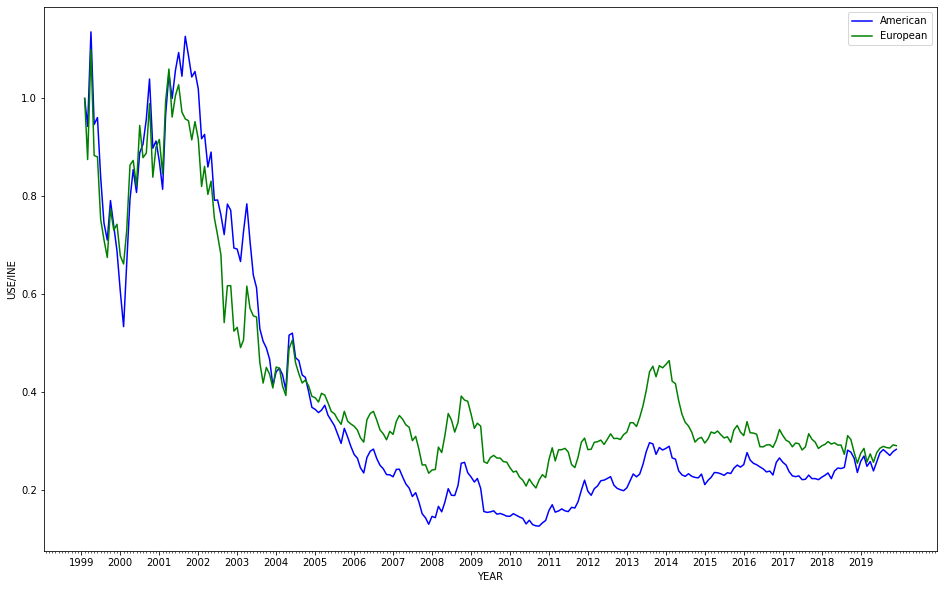

In [51]:
# truncating usd/inr to correspond to rest of data
us_fit =usdinr.truncate(before=313, after=563).DEXINUS.tolist()

ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_minor_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

fig = plt.gcf() 
fig.set_size_inches(16,10)

plt.xticks(list(map(lambda x: datetime.date(x,1,1), list(range(1999,2020,1)))))

plt.xlabel('YEAR')
plt.ylabel('USE/INE')

us_rry = np.array(use)*np.array(us_fit)/np.array(ine)
eu_rry = np.array(eue)*np.array(us_fit)*np.array(eurusd.truncate(before=1,after=251).DEXUSEU)/np.array(ine)

mnths = list(map( lambda x: datetime.date(int(x[0:4]),int(x[5:7]),1), dow.Date.tolist()))

plt.plot(mnths, us_rry/ us_rry[0], 'b', label="American")
plt.plot(mnths, eu_rry/ eu_rry[0], 'g', label="European")
plt.legend(loc="upper right")
plt.savefig('plots/equity_rel.png',  bbox_inches='tight')
plt.show()

view 2

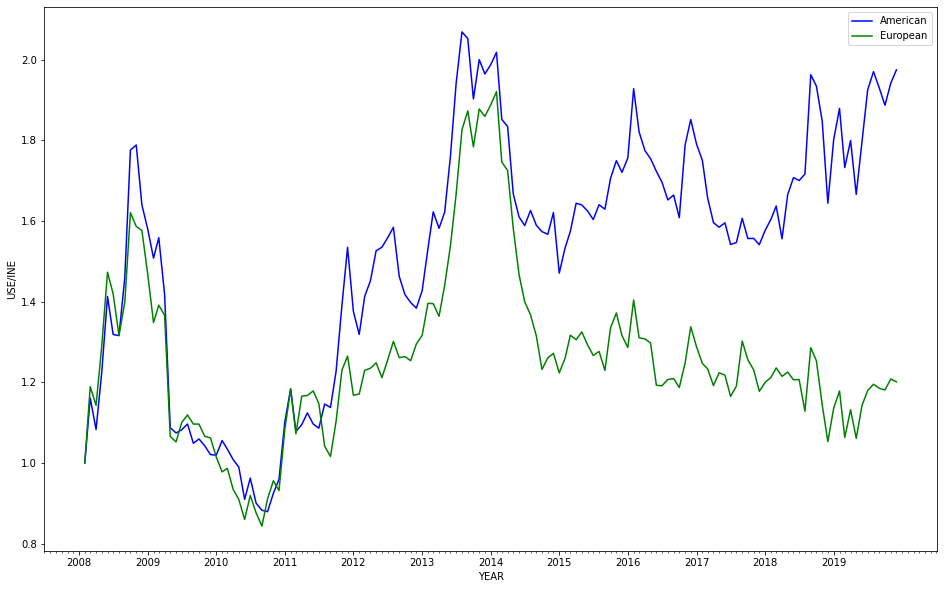

In [52]:
# truncating usd/inr to correspond to rest of data
us_fit =usdinr.truncate(before=313, after=563).DEXINUS.tolist()

ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_minor_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

fig = plt.gcf() 
fig.set_size_inches(16,10)

plt.xticks(list(map(lambda x: datetime.date(x,1,1), list(range(1999,2020,1)))))

plt.xlabel('YEAR')
plt.ylabel('USE/INE')

us_rry = us_rry[108:]
eu_rry = eu_rry[108:]

mnths = mnths[108:]

plt.plot(mnths, us_rry/ us_rry[0], 'b', label="American")
plt.plot(mnths, eu_rry/ eu_rry[0], 'g', label="European")
plt.legend(loc="upper right")
plt.savefig('plots/equity_rel_2.png',  bbox_inches='tight')
plt.show()

you can get this notebook from my [github](https://github.com/praneethmendu/Notebooks/tree/master/intrestAdj)